# Assignment - 15 - This is 

Name : Nihar Kanungo, Manjunath  (EVA-2, Batch : 6:30 AM , Sunday)

Background :
-------------
The Purpose of this assignment is to understand the use of 

1. Eager Execution and 
2. Tf Recordset and Tf Data API

The expectation is to use the Davidnet model and train the model to achieve 93% accuracy in 24 epochs . 

Once done the same network must run using the TF record Dataset to see the improvement. (However we may not see any improvement in this notebook as we are not reading the images from distributed file systems )

Regarding TF Data API 
------------------------------
The tf.data API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

Requirements
--------------
Run the following code: Colab 93%, 24 Epochs, 858 seconds LINK (Links to an external site.)

Move the code to Tensorflow Eager Mode

Move the data to TFRecords

Train the Network using TF record 

Submit



Environment
--------------
Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm : Davidnet


Referrences & further reading 
------------------------------

https://www.tensorflow.org/guide/data

https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset

https://www.tensorflow.org/tutorials/load_data/tfrecord


https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/
18_TFRecords_Dataset_API.ipynb

https://github.com/kalaspuffar/tensorflow-data


Videos
-----------------

https://www.youtube.com/watch?v=oxrcZ9uUblI

https://www.youtube.com/watch?v=bqeUmLCgsVw&feature=youtu.be




Basic Imports
---------------

In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
from imgaug import augmenters as iaa

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Some more imports which we would be using while reading and writting to Google Drive (for future reference)

In [0]:
import os, sys
from six.moves import cPickle as pickle

from google.colab import drive

#drive.mount('/gdrive')

#!ls "/gdrive/My Drive/datasets/tfrecords/cifar10/preprocessed"

For running the Eager Execution 

In [0]:
tf.enable_eager_execution()


# Define Hyper Parameters 

In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

# for deterministic initialization of kernel weights

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

# Define a class which performs convolution followed by Batch Normalization . The method below performs relu activation.

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

# Define the Resnet Block class which would be used in the Davidnet Model 

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

# Define DavidNet model class 

( The details of the model is available in the link https://myrtle.ai/how-to-train-your-resnet/)

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    outval = tf.argmax(h, axis = 1)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct,outval.numpy()

# Download the CIFAR data and calculate the mean and standard deviation of the data 

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train/255, axis=(0,1,2))
train_std = np.std(x_train/255, axis=(0,1,2))



170500096/170498071 [==============================] - 4s 0us/step


In [10]:
print(train_mean)
print(train_std)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Print Statements for understanding of the data 



In [13]:
# for debug
!pwd
print("x_train.type() - ", type(x_train))
#print("x_train.dir() - ", dir(x_train))
print("x_train.ndim - ", x_train.ndim)
print("x_train.shape - ", x_train.shape)
print("x_train.size - ", x_train.size)
print("x_train.dtype - ", np.dtype(x_train[0][0][0][0]))
print("len_train =", len_train)
print()
print("y_train.type() - ", type(y_train))
#print("y_train.dir() - ", dir(y_train))
print("y_train.ndim - ", y_train.ndim)
print("y_train.shape - ", y_train.shape)
print("y_train.size - ", y_train.size)
print("y_train.dtype - ", np.dtype(y_train[0]))
print("len_test =", len_test)

/content
x_train.type() -  <class 'numpy.ndarray'>
x_train.ndim -  4
x_train.shape -  (50000, 32, 32, 3)
x_train.size -  153600000
x_train.dtype -  uint8
len_train = 50000

y_train.type() -  <class 'numpy.ndarray'>
y_train.ndim -  1
y_train.shape -  (50000,)
y_train.size -  50000
y_train.dtype -  int64
len_test = 10000


Image Functions
------------------
1. Normalize the image 
2. Perform 4 x 4 padding 

In [0]:
#normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
#pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# x_train = normalize(pad4(x_train))
# x_test = normalize(x_test)
# x_train = normalize(x_train)
# x_test = normalize(x_test)


Now let's define the TF record and see how the training behaves using the Tf record dataset

TFRecord and tf.Example
------------------------
To read data efficiently it can be helpful to serialize your data and store it in a set of files (100-200MB each) that can each be read linearly. This is especially true if the data is being streamed over a network. This can also be useful for caching any data-preprocessing.

The TFRecord format is a simple format for storing a sequence of binary records.


A TFRecord file contains a sequence of records. The file can only be read sequentially.

Each record contains a byte-string, for the data-payload, plus the data-length, and CRC32C (32-bit CRC using the Castagnoli polynomial) hashes for integrity checking.


# TF Record write Functions
------------------
1. Define the tf.examples data type conversion helper functions
2. Define function to write to file as tfrecord 

In [11]:
#!pip install opencv-contrib-python
import cv2
from google.colab.patches import cv2_imshow
class tf_record_operations:

  def rotate(img,angle):
    img = tf.make_ndarray(img)
    print(type(img))
    rows,cols,ht = img.shape
    #rows = rows[0]
    rows = 32
    cols = 32
    print('type of row is',type(rows))
    image_center = (int(rows//2),int(cols//2))
    print('image dimensions are', rows//2,cols//2,ht)
    print(type(image_center), image_center)
    matrix = cv2.getRotationMatrix2D(image_center,angle,1)
    new_img = cv2.warpAffine(img,matrix,(cols,rows))
    return new_img

  def cutout(input_img, s_l=0.04, s_h=0.06,proba=1.0, r_1=0.35, r_2=1 / 0.35,
                        max_erasures_per_image=1, pixel_level=True):
      """
      :param p:
      :param s_l: Minimum Area Proportion of Original that may be cut
      :param s_h: Maximum Area Proportion of Original that may be cut
      :param r_1: Min Aspect Ratio
      :param r_2: Max Aspect Ratio
      :param max_erasures_per_image:
      :param pixel_level:
      :return: Eraser to be used as Preprocessing Function
      """
      input_img = input_img
      assert max_erasures_per_image >= 1
      if s_l > 1 :
        s_l = 1/s_l
      if s_h > 1 :
        s_h = 1/s_h
    
      p_1 = np.random.rand()
      if p_1 > proba:
          return input_img
      img_h, img_w, img_c = input_img.shape
      shape = input_img.shape

      v_l = np.min(input_img)
      v_h = np.max(input_img)

    #         mx = np.random.randint(1, max_erasures_per_image + 1)
      mx = max_erasures_per_image
      for i in range(mx):
          while True:
              s = np.random.uniform(s_l, s_h) * img_h * img_w
              r = np.random.uniform(r_1, r_2)
              w = int(np.sqrt(s / r))
              h = int(np.sqrt(s * r))
              left = np.random.randint(0, img_w)
              top = np.random.randint(0, img_h)

              if left + w <= img_w and top + h <= img_h:
                  break

          if pixel_level:
              c = np.random.uniform(v_l, v_h, (h, w, img_c))
          else:
              c = np.random.uniform(v_l, v_h)

          input_img[top:top + h, left:left + w, :] = c

      return input_img


  def random_flip(img,flip = 0.5):
    img = img
    seq = iaa.Sequential([
      iaa.Fliplr(flip) # horizontally flip 50% of the images
    ])
    img = seq(images=img)
    return img

  def random_pad_crop(img, padding_size=4,random_crop_size=32):
      img = img
      print('image shape is', img.shape)
      x = np.pad(img, ((padding_size,padding_size),(padding_size,padding_size),(0,0)), mode='constant',)
      w, h = x.shape[0], x.shape[1]
      rangew = (w - random_crop_size) // 2
      rangeh = (h - random_crop_size) // 2
      offsetw = 0 if rangew == 0 else np.random.randint(rangew)
      offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
      return x[offsetw:offsetw+random_crop_size, offseth:offseth+random_crop_size,:]

  def normalize_img(img):
    img = img
    img = img/255
    img = (img - mu)/sigma
    
    return img

  def transform(img):
    img = img
    print(cv2_imshow(img))
    return img




  class data:
    
    def print_progress(count, total):
    # Percentage completion.
      pct_complete = float(count) / total

      # Status-message.
      # Note the \r which means the line should overwrite itself.
      msg = "\r- Progress: {0:.1%}".format(pct_complete)

      # Print it.
      sys.stdout.write(msg)
      sys.stdout.flush()

#conversion sequence
#dataset -> list -> feature -> example -> ToString -> write to file as tfrecord
    def int64_feature(value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def float32_feature(value):
      return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1))) 

    def bytes_feature(value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

      
    def convert_to_tfRecords(feature= x_train,label=y_train,file_name='train.tfrecords'):
      print('feature is ', len(feature))
      print('label is', len(label))
      print('file is ', file_name)
    # def prepare_tf_records(mode):
      # output_files = {'train': 'train.tfrecords', 'test': 'test.tfrecords'}
      # lengths = {'train': len_train, 'test': len_test}
      # input_data = {'train': x_train, 'test': x_test}
      # output_data = {'train': y_train, 'test': y_test}

      with tf.python_io.TFRecordWriter(file_name) as record_writer:
        num_entries = len(feature)
        data = feature
        labels = label
        print('num_entries = ', num_entries)
        for i in range(num_entries):
          tf_record_operations.data.print_progress(count=i, total=num_entries-1)
          one_image = data[i,::]
          one_label = labels[i]
          #image_size = one_image.shape[0]
          example = tf.train.Example(features=tf.train.Features(
              feature={
                  'image': tf_record_operations.data.float32_feature(one_image), 
                  'label': tf_record_operations.data.int64_feature(one_label)
              }))
          record_writer.write(example.SerializeToString()) 
#a = tf_record_operations      
tf_record_operations.data.convert_to_tfRecords(feature =x_train,label=y_train,file_name='train.tfrecords')
tf_record_operations.data.convert_to_tfRecords(feature =x_test,label=y_test,file_name='test.tfrecords')

feature is  50000
label is 50000
file is  train.tfrecords
num_entries =  50000
- Progress: 100.0%feature is  10000
label is 10000
file is  test.tfrecords
num_entries =  10000
- Progress: 100.0%

In [44]:
#print(x_train.shape[1::])
# tf_record_operations.transform(tf_record_operations.random_pad_crop(tf_record_operations.random_flip(tf_record_operations.cutout(tf_record_operations.rotate(x_train[2], 10), 8,8)), 4, 32))

<class 'numpy.ndarray'>


TypeError: ignored

# Print Statements

Let's write some print statements which would help us to see the converted data formats and all other statistics 

In [16]:

data = x_train
print("data.type() - ", type(data))
print("data.ndim - ", data.ndim)
print("data.shape - ", data.shape)
print("data.size - ", data.size)
print("data.dtype - ", np.dtype(data[0][0][0][0]))

one_image = data[0,::]
print("one_image.shape - ", one_image.shape)
print("one_image.shape - ", one_image.shape[0])

data.type() -  <class 'numpy.ndarray'>
data.ndim -  4
data.shape -  (50000, 32, 32, 3)
data.size -  153600000
data.dtype -  float32
one_image.shape -  (32, 32, 3)
one_image.shape -  32


# Parser Function

The TFRecords files contain the data in a serialized binary format which needs to be converted back to images and labels of the correct data-type. We use a helper-function for this parsing.

# Read the data 
function  that reads from TFRecords files for use with the davidnet model



In [12]:
#tfrecords file -> tfrecordDataset -> features -> image, label
#parser works on given input(tfrecords file), similar to an apple cutter on a given apple

def parser(serialized_example, img_sz):
  """Parses a single tf.Example into image and label tensors."""
  # Dimensions of the images in the CIFAR-10 dataset.
  # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
  # input format.
  parsed_example = tf.parse_single_example(
      serialized = serialized_example,
      features = {
          'image': tf.FixedLenFeature([img_sz*img_sz*3], tf.float32),
          'label': tf.FixedLenFeature([], tf.int64),
      })

  image = tf.cast(
      tf.reshape(parsed_example['image'], [img_sz, img_sz, 3]),
      tf.float32)
  label = tf.cast(parsed_example['label'], tf.int64)

  # Custom preprocessing.
  #image = self.preprocess(image)

  return image, label

# helper-function for creating an function that reads from TFRecords files for use with the Davidnet Model

def read_tf_records(mode, file_name, image_size):
  # Create a list of filenames and pass it to a queue
  file_names = [file_name]
  raw_dataset = tf.data.TFRecordDataset(file_names)
  parsed_image_dataset = raw_dataset.map(lambda x: parser(x, image_size))
  
  
  
  ####################################
  print("parsed_image_dataset.type() - ", type(parsed_image_dataset))
  print("parsed_image_dataset.dir - ", dir(parsed_image_dataset))
  print("parsed_image_dataset.output_classes - ", tf.compat.v1.data.get_output_classes(parsed_image_dataset))
  print("parsed_image_dataset.output_shapes - ", tf.compat.v1.data.get_output_shapes(parsed_image_dataset))
  print("parsed_image_dataset.output_types - ", tf.compat.v1.data.get_output_types(parsed_image_dataset))
  ####################################
  x = []
  y = []
  for image_features in parsed_image_dataset:
    x.append(image_features[0].numpy()) #image (EagerTensor to numpy array)
    y.append(image_features[1].numpy()) #label (EagerTensor to numpy array)
  print("x.type() - ", type(x))

  x = np.asarray(x) #(numpy array to ndarray)
  y = np.asarray(y) #(numpy array to ndarray)
  return x, y

# Let's store the data read into the variables to be used for training 

x_train, y_train = read_tf_records('train', '/content/train.tfrecords', 32)
x_test, y_test = read_tf_records('test', '/content/test.tfrecords', 32)




parsed_image_dataset.type() -  <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>
parsed_image_dataset.dir -  ['_GeneratorState', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_as_variant_tensor', '_checkpoint_dependencies', '_component_metadata', '_consumers', '_dataset', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_from_components', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_ca

# Some Print Statements to help us understand the data better 

In [19]:

print("x_train.type() - ", type(x_train))
#print("x_train.dir() - ", dir(x_train))
print("x_train.ndim - ", x_train.ndim)
print("x_train.shape - ", x_train.shape)
print("x_train.size - ", x_train.size)
print("len(x_train) = ", len(x_train))

print()
print("y_train.type() - ", type(y_train))
#print("y_train.dir() - ", dir(y_train))
print("y_train.ndim - ", y_train.ndim)
print("y_train.shape - ", y_train.shape)
print("y_train.size - ", y_train.size)
print("len(y_train) = ", len(y_train))

x_train.type() -  <class 'numpy.ndarray'>
x_train.ndim -  4
x_train.shape -  (50000, 32, 32, 3)
x_train.size -  153600000
len(x_train) =  50000

y_train.type() -  <class 'numpy.ndarray'>
y_train.ndim -  1
y_train.shape -  (50000,)
y_train.size -  50000
len(y_train) =  50000


# Model object and other features for training 

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
normalize = lambda x: (tf.cast(x, tf.float32)/255 - train_mean) / train_std

random_crop = lambda x,n: tf.random_crop(x, [n, n, 3])
random_flip_left_right = lambda x: tf.image.random_flip_left_right(x)
pad = lambda x, n: tf.pad(x, [[n, n], [n, n], [0, 0]], mode='reflect')
random_rotate = lambda x, n: tf.contrib.image.rotate(x, (np.random.rand()-0.5)*math.pi/180*n)
def cutout(x, si, sj):
    ci = tf.random.uniform((1,), 0, x.shape[0] - si - 1, dtype=tf.int32)[0]
    cj = tf.random.uniform((1,), 0, x.shape[1] - sj - 1, dtype=tf.int32)[0]
    idx = [tf.range(ci, si), tf.range(cj, sj)]
    val = tf.zeros((si, sj, 3))
    tf.tensor_scatter_update(x, idx, val)
    return x
#image_augment = lambda x,y:( cutout(normalize(random_rotate(random_crop(random_flip_left_right(pad(x, 4)), 32), 10)), 8, 8),y)
image_augment = lambda x,y:(random_crop(pad(random_flip_left_right(cutout(random_rotate(x,10),8,8)),4),32),y)



# This is to check if eager model is running or not 

In [14]:
tf.executing_eagerly()

True

# Model Training and validation 

In [15]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(image_augment).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.6025878765869142 train acc: 0.41802 val loss: 1.3501087860107421 val acc: 0.5274 time: 93.37828850746155



epoch: 2 lr: 0.16 train loss: 0.922026962890625 train acc: 0.67172 val loss: 1.0860719696044923 val acc: 0.6243 time: 172.9193470478058



epoch: 3 lr: 0.24 train loss: 0.6564236721801758 train acc: 0.76972 val loss: 0.8706237670898438 val acc: 0.7071 time: 251.64296436309814



epoch: 4 lr: 0.32 train loss: 0.5469452996826172 train acc: 0.80992 val loss: 0.7137446365356446 val acc: 0.7586 time: 331.2102930545807



epoch: 5 lr: 0.4 train loss: 0.47725011840820314 train acc: 0.83536 val loss: 0.8912722534179688 val acc: 0.71 time: 410.2677249908447



epoch: 6 lr: 0.37894736842105264 train loss: 0.40916382537841794 train acc: 0.85876 val loss: 0.6397873657226563 val acc: 0.7889 time: 489.17881631851196



epoch: 7 lr: 0.35789473684210527 train loss: 0.31884133712768553 train acc: 0.89108 val loss: 0.3895025314331055 val acc: 0.8667 time: 568.5619130134583



epoch: 8 lr: 0.33684210526315794 train loss: 0.337555223236084 train acc: 0.8828 val loss: 0.418914054107666 val acc: 0.8622 time: 648.2469992637634



epoch: 9 lr: 0.31578947368421056 train loss: 0.28219505294799807 train acc: 0.90168 val loss: 0.43253956909179686 val acc: 0.8573 time: 727.0690174102783



epoch: 10 lr: 0.2947368421052632 train loss: 0.22695119552612306 train acc: 0.92014 val loss: 0.3988729995727539 val acc: 0.8691 time: 806.1430480480194



epoch: 11 lr: 0.2736842105263158 train loss: 0.21893036529541016 train acc: 0.92314 val loss: 0.4674234191894531 val acc: 0.8621 time: 885.4093329906464



epoch: 12 lr: 0.25263157894736843 train loss: 0.17590170211791992 train acc: 0.93864 val loss: 0.38931967391967776 val acc: 0.8783 time: 964.620100736618



epoch: 13 lr: 0.23157894736842108 train loss: 0.14078034713745116 train acc: 0.95178 val loss: 0.3443797302246094 val acc: 0.8883 time: 1043.787525653839



epoch: 14 lr: 0.2105263157894737 train loss: 0.15181615005493165 train acc: 0.94684 val loss: 0.3543036834716797 val acc: 0.8853 time: 1123.127474308014



epoch: 15 lr: 0.18947368421052635 train loss: 0.12550347137451173 train acc: 0.95684 val loss: 0.3127800231933594 val acc: 0.9049 time: 1202.0005683898926



epoch: 16 lr: 0.16842105263157897 train loss: 0.10511339904785157 train acc: 0.96424 val loss: 0.30254691848754883 val acc: 0.9072 time: 1281.0560784339905



epoch: 17 lr: 0.1473684210526316 train loss: 0.07838145698547364 train acc: 0.9732 val loss: 0.26742039794921874 val acc: 0.9173 time: 1360.0948040485382



epoch: 18 lr: 0.12631578947368421 train loss: 0.06394775379180909 train acc: 0.97944 val loss: 0.29401928787231446 val acc: 0.9139 time: 1439.2137846946716



epoch: 19 lr: 0.10526315789473689 train loss: 0.08485724193572998 train acc: 0.97086 val loss: 0.3136369812011719 val acc: 0.9061 time: 1518.4741835594177



epoch: 20 lr: 0.08421052631578951 train loss: 0.06674849300384522 train acc: 0.9781 val loss: 0.26872501220703127 val acc: 0.9192 time: 1597.1775822639465



epoch: 21 lr: 0.06315789473684214 train loss: 0.07526526458740235 train acc: 0.97426 val loss: 0.26648399391174316 val acc: 0.9214 time: 1675.7196345329285



epoch: 22 lr: 0.04210526315789476 train loss: 0.0443532957649231 train acc: 0.98646 val loss: 0.24617481575012207 val acc: 0.9267 time: 1754.3100576400757



epoch: 23 lr: 0.02105263157894738 train loss: 0.054339976596832276 train acc: 0.983 val loss: 0.2590259765625 val acc: 0.9264 time: 1833.3701293468475



epoch: 24 lr: 0.0 train loss: 0.03075043489456177 train acc: 0.99194 val loss: 0.23982546768188476 val acc: 0.9272 time: 1912.5765562057495


In [0]:
model.save_weights('modelweights.h5')
model.load_weights('modelweights.h5')

results = []

for (x, y) in test_set:
    loss, correct, res = model(x, y)
    results.append(res)
    
results = np.concatenate(results)


In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_image(nx, ny, X, Y, results=None, ptype='random', pclass=-1):
    l = len(Y)
    idx = np.zeros((nx, ny), dtype='int')
    title = ""
    if ptype == 'random': 
        idx = np.random.randint(0, len(Y), size=(nx, ny))
        title = "Random images"
    elif ptype == 'class':
        if pclass < 0:
            raise Exception("Specific class should be defined.")
        title = "{0:s} class images".format(cifar10_classes[pclass].capitalize())
        k = 0
        for i in range(nx):
            for j in range(ny):
                while Y[k] != pclass: k+=1
                idx[i, j] = k
                k += 1
    elif ptype == 'missed':
        if results is None:
            raise Exception("results cannot be None for misclassified images")
        
        if pclass < 0 :
            title = "Misclassified images"
        else: 
            title = "Misclassified {0:s} class images".format(cifar10_classes[pclass].capitalize())
        
        k = 0
        for i in range(nx):
            if k >= l:
                break
            for j in range(ny):
                if pclass == -1: 
                    while (Y[k] == results[k]): k+=1
                else:
                    while Y[k] != pclass or (Y[k] == results[k]): k+=1
                if k >= l:
                    break
                idx[i, j] = k
                k += 1

    fig, ax = plt.subplots(nx, ny, figsize = (3*nx, 3*ny))
    fig.suptitle(title)
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    
    for (ix, iy) in [(i, j) for i in range(nx) for j in range(ny)]:
        ii = idx[ix, iy]
        ax[ix, iy].imshow(X[ii].astype('uint8'))
        ax[ix, iy].axis('off')
        acls = cifar10_classes[Y[ii]]
        if results is None:
            pcls = "none"
        else:
            pcls = cifar10_classes[results[ii]]
        ax[ix, iy].set_title('%d A: %s P: %s' % (ii, acls, pcls))

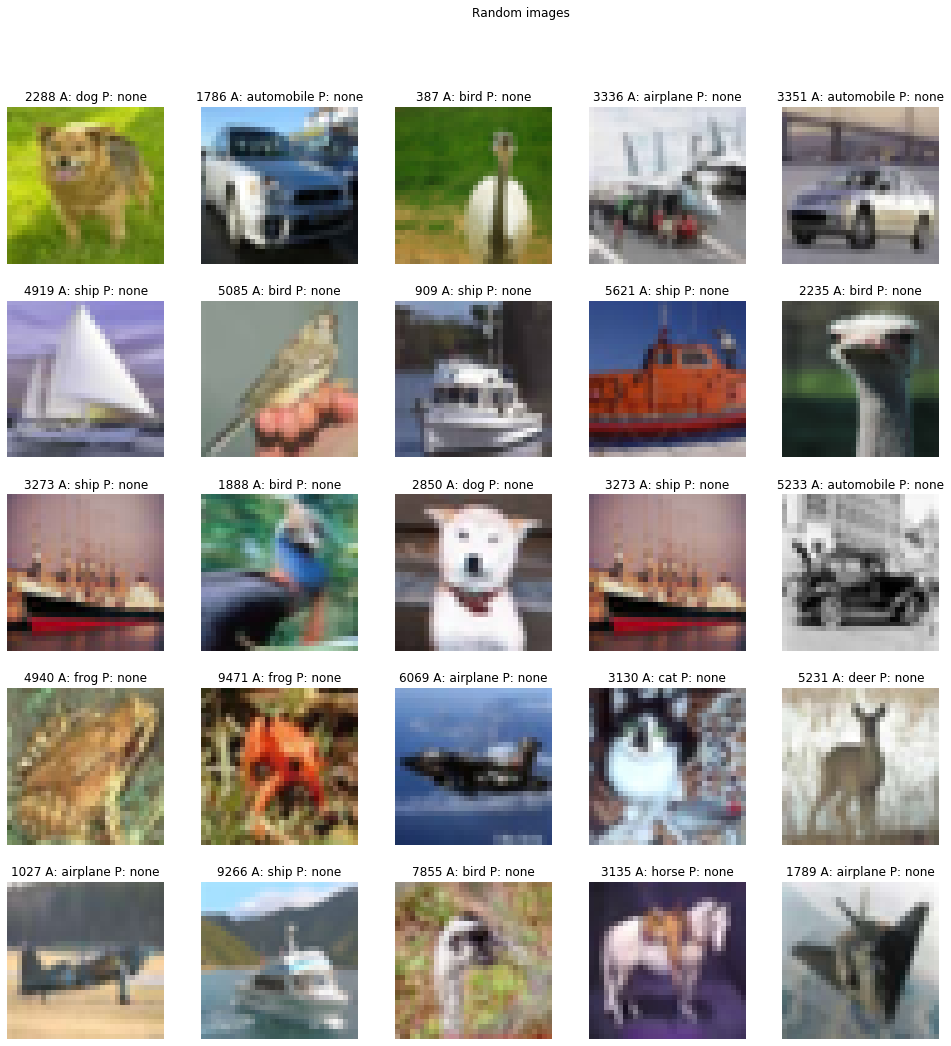

In [33]:
X, Y = x_test, y_test
plot_image(5, 5, X,Y)

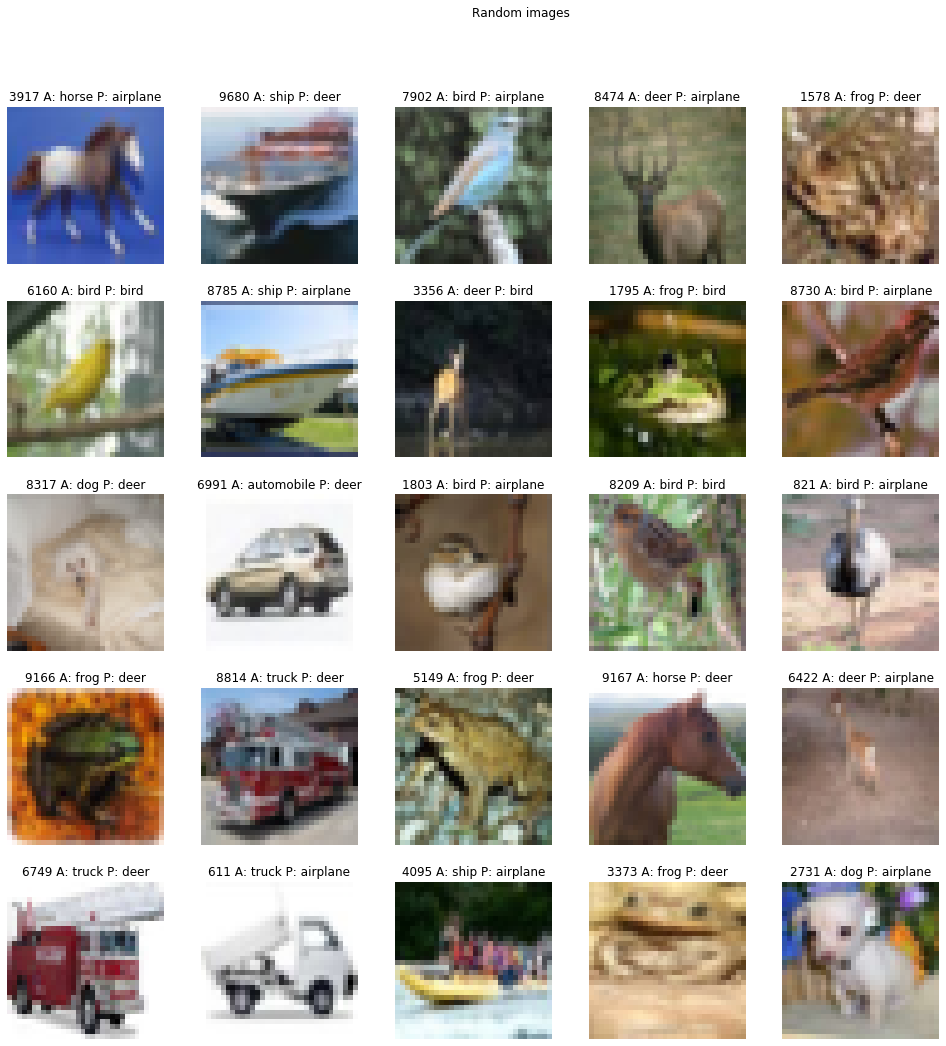

In [34]:
plot_image(5, 5, X, Y, results)

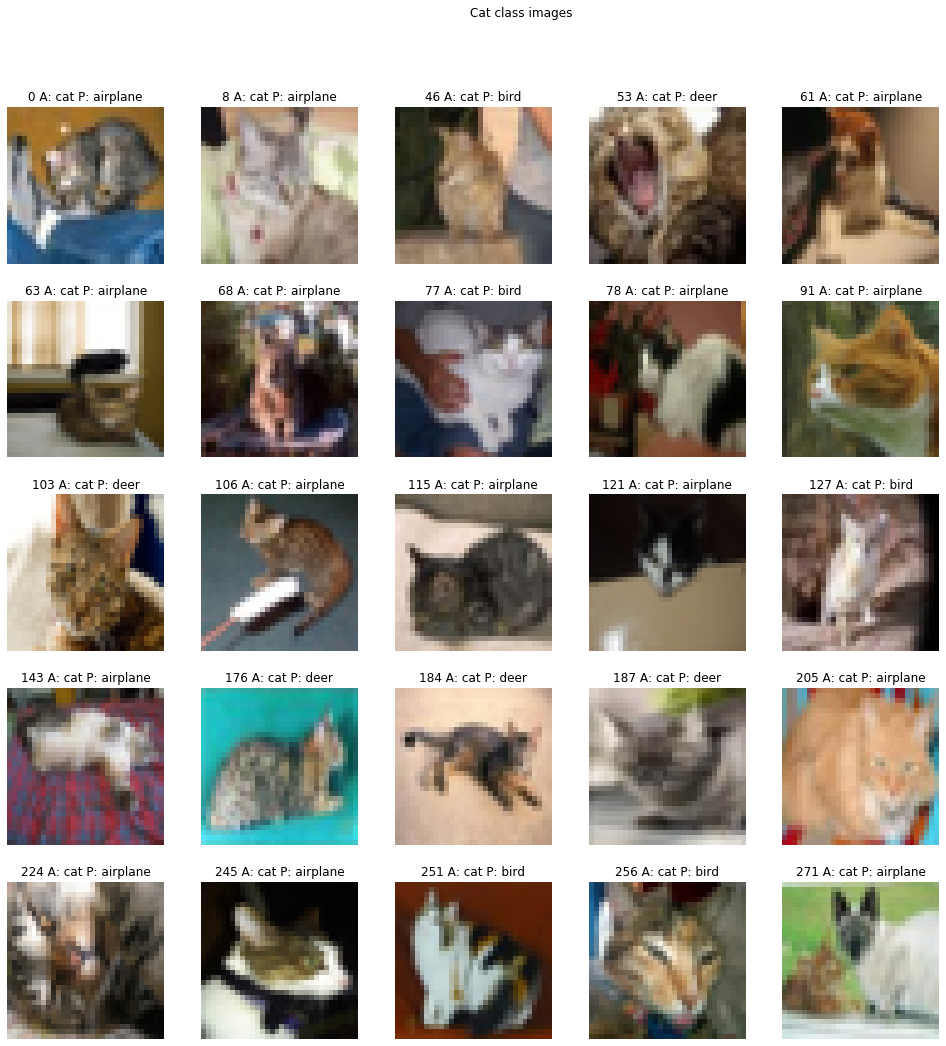

In [35]:
plot_image(5, 5, X, Y, results, ptype='class', pclass=3)

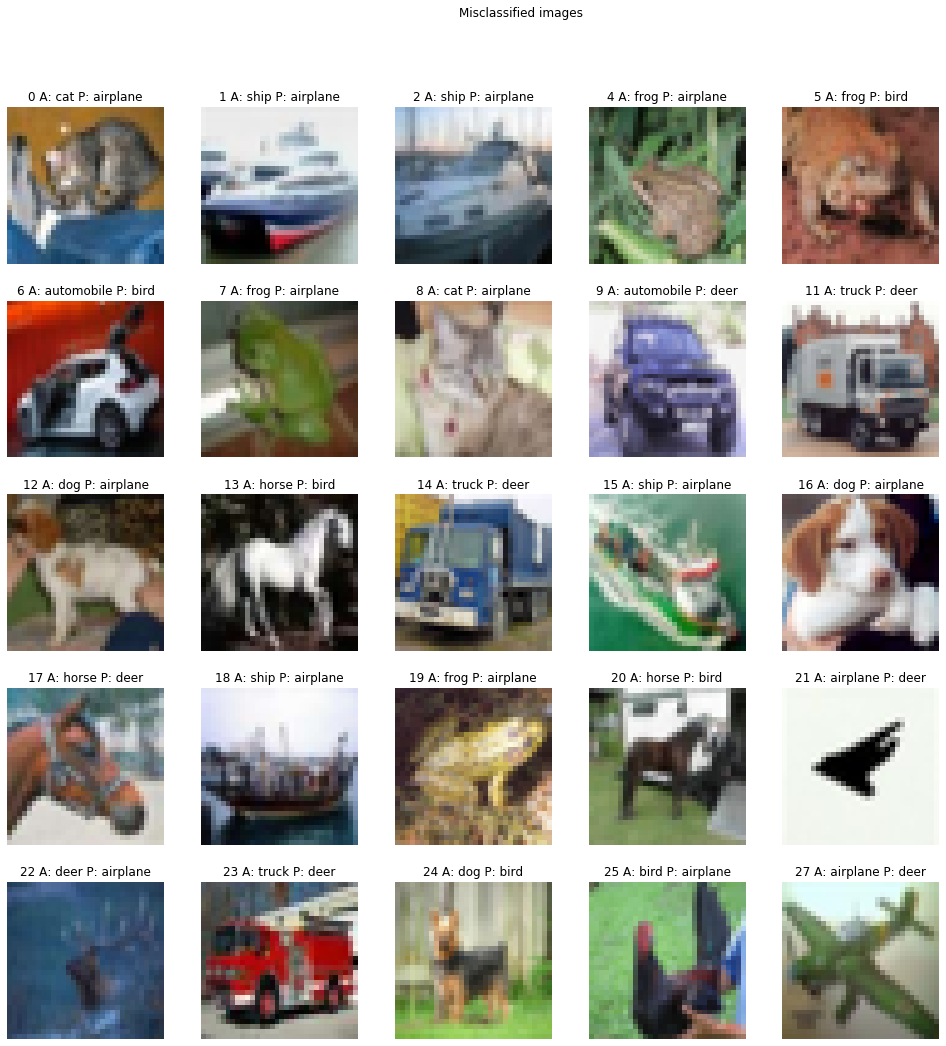

In [36]:
plot_image(5, 5, X, Y, results, ptype='missed')

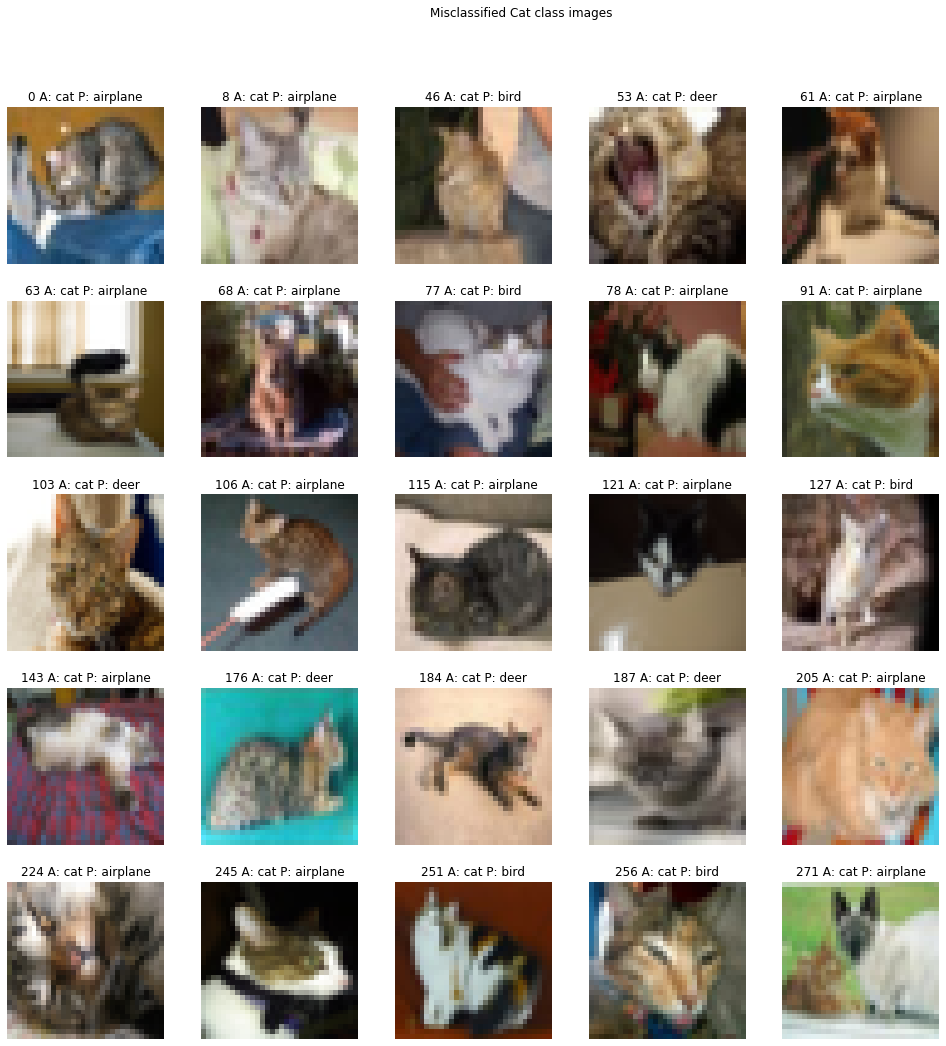

In [37]:
plot_image(5, 5, X, Y, results, ptype='missed', pclass=3)

Observation
------------

The Model ran for 30 epochs in 658 secs with highest validation accuracy of 92.99 %. Now let's run it for few more epochs to see if it's reaching the 93% mark 